## 3-Link Arms : 3x2 Inverse Kinematics with Jacobian Matrix

In [28]:
%matplotlib notebook
import numpy as np
from numpy.linalg import inv, pinv, norm
import matplotlib.pyplot as plt

In [29]:
# Forward Kinematics

def FK(L, TH, plot=False):
    x0 = 0
    x1 = x0 + L[0] * np.cos(TH[0])
    x2 = x1 + L[1] * np.cos(TH[0] + TH[1])
    x3 = x2 + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    y0 = 0
    y1 = y0 + L[0] * np.sin(TH[0])
    y2 = y1 + L[1] * np.sin(TH[0] + TH[1])
    y3 = y2 + L[2] * np.sin(TH[0] + TH[1] + TH[2])
    X = [x0, x1, x2, x3]
    Y = [y0, y1, y2, y3]
    if plot:
        return X, Y
    else:
        return np.array([[x3, y3]])

def Plot(X, Y):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.axis([-1,N+1,-1,N+1])
    ax.grid()
    ax.plot(X, Y)
    ax.scatter(X, Y)
    ax.plot(Target[0], Target[1], marker='x', ms=20, color='red')
    ax.text(X[0], Y[0]-0.4, 'Base', ha='center')
    ax.text(X[-1], Y[-1]+0.2, 'End Effector', ha='left')
    ax.text(Target[0], Target[1]-0.2, 'Target', ha='left', va='top', color='red')

## Plot the result of FK

<IPython.core.display.Javascript object>


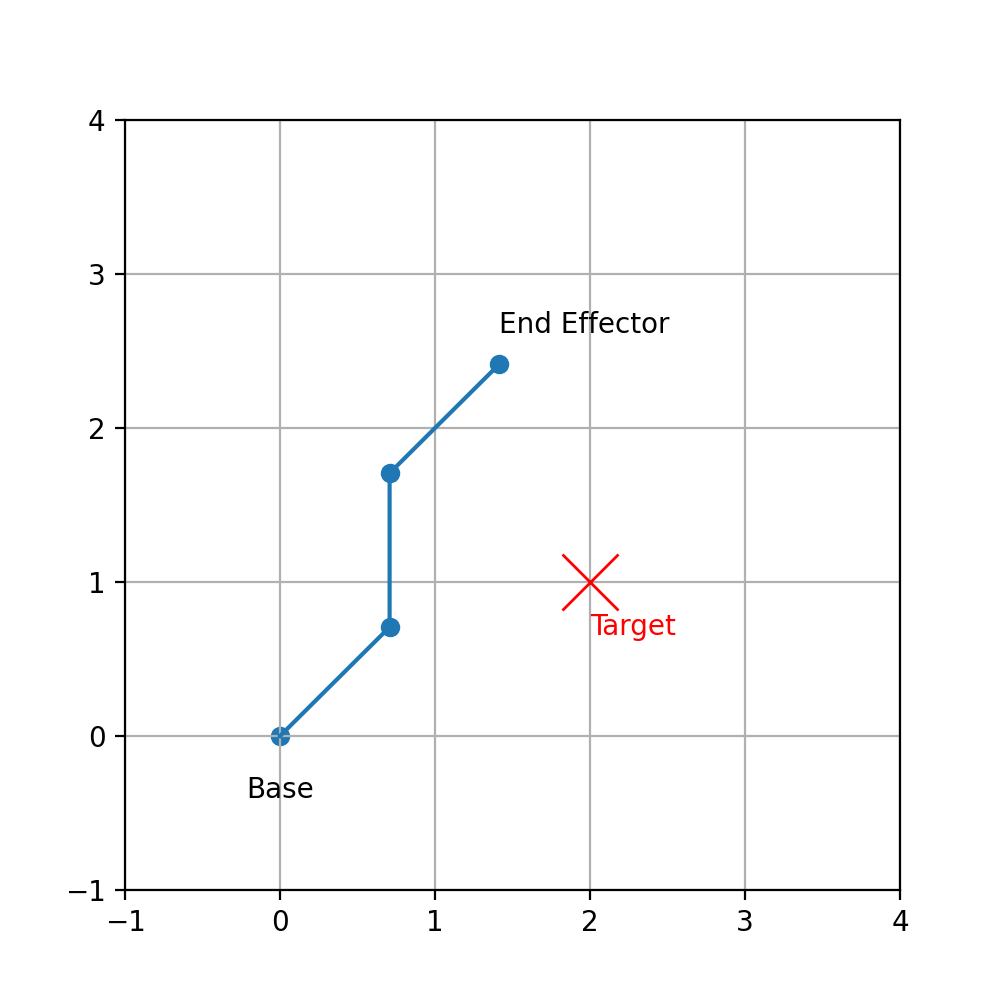

End-effector:  x = 1.4142135623730954 , y = 2.414213562373095


In [30]:
Target = np.array([2.0, 1.0])  # dummy target
L = [1, 1, 1]                  # length of links
TH = np.radians([45, 45, -45]) # angle at each joint
N = len(L)                     # the number of links

X, Y = FK(L, TH, plot=True)
Plot(X, Y)
print('End-effector:  x =',X[-1], ', y =', Y[-1])

## IK with 3x2 Pseudo-inverse Jacobian Matrix

<IPython.core.display.Javascript object>


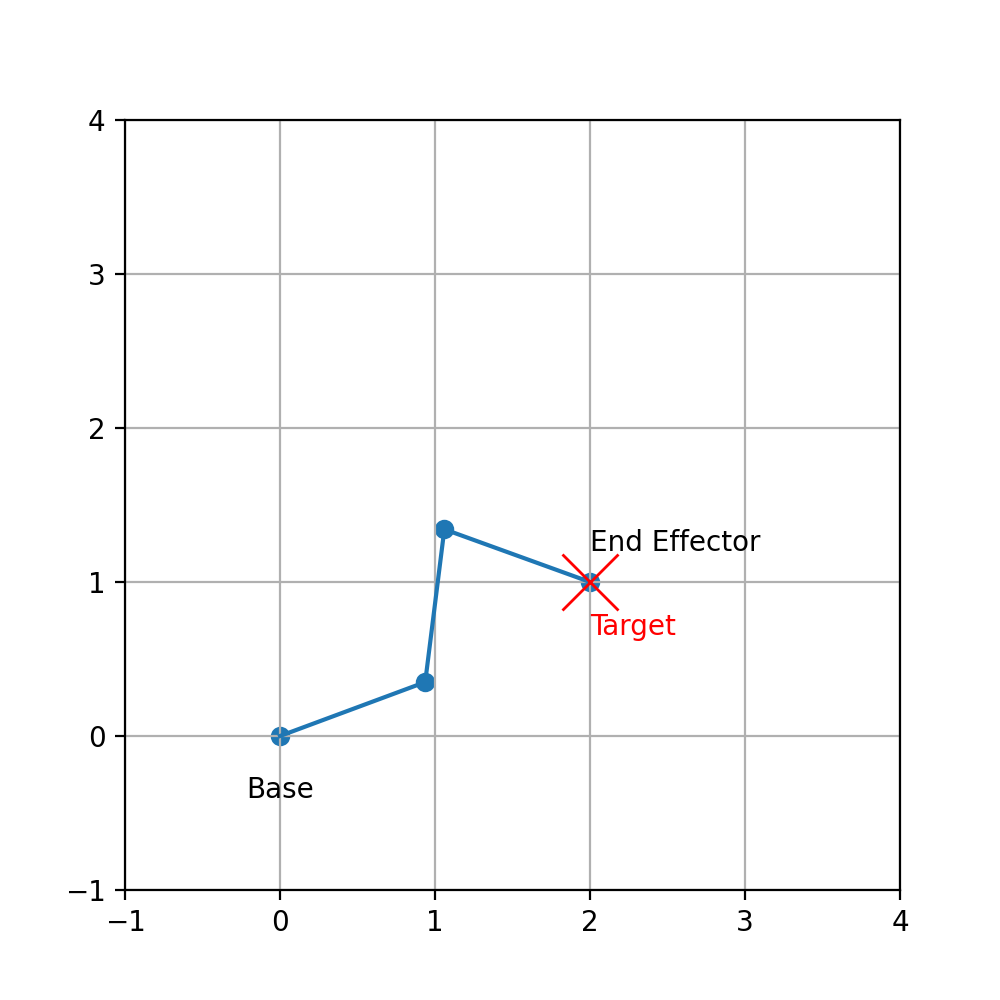

Target      :  x = 2.0 , y = 1.0
End-effector:  x = 1.999996388160604 , y = 1.0000075263118693
Error(< 1e-5): 9.275665366346972e-06
Loops: 115


In [31]:
# Inverse Kinematics with Jacobian Matrix

def Jacobian(L, TH): # returns 2x3 Jacobian Matrix
    # FK: x =   L[0] * np.cos(TH[0]) + L[1] * np.cos(TH[0] + TH[1]) + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    dx_dth1 = - L[0] * np.sin(TH[0]) - L[1] * np.sin(TH[0] + TH[1]) - L[2] * np.sin(TH[0] + TH[1] + TH[2])
    dx_dth2 =                      0 - L[1] * np.sin(TH[0] + TH[1]) - L[2] * np.sin(TH[0] + TH[1] + TH[2])
    dx_dth3 =                      0 -                            0 - L[2] * np.sin(TH[0] + TH[1] + TH[2])
    
    # FK: y =   L[0] * np.sin(TH[0]) + L[1] * np.sin(TH[0] + TH[1]) + L[2] * np.sin(TH[0] + TH[1] + TH[2])
    dy_dth1 =   L[0] * np.cos(TH[0]) + L[1] * np.cos(TH[0] + TH[1]) + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    dy_dth2 =                      0 + L[1] * np.cos(TH[0] + TH[1]) + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    dy_dth3 =                      0 +                            0 + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    
    J = np.array([[dx_dth1, dx_dth2, dx_dth3],
                  [dy_dth1, dy_dth2, dy_dth3]])
    return J

Target = np.array([2.0, 1.0])  # target vector to be specified
L = np.array([1, 1, 1])        # lengh of each link
TH = np.radians([45, 45, -45]) # angle of each joint
N = len(L)                     # the number of links

TN = norm(Target)
if sum(L) - TN <= 0:
    Target = Target * sum(L) / TN # if not reachable to the target, the target vector will be overwritten as a reachable vector
    print('Target overwritten:', Target)

scaler = 0.1 # scaler to get a smooth transition(but slower)
loops = 0    # loop counter
while True:                     # loops until End-Effector meets Target
    J = Jacobian(L, TH)         # returns 2x3 Jacobian Matrix
    Err = Target - FK(L, TH)    # error between Target vector and Current End-effector vector
    dTheta = pinv(J, rcond=1e-15) @ Err.T    # Moore-Penrose Pseudo-inverse Matrix: J.T @ inv(J @ J.T)
    TH += dTheta[:, 0] * scaler # add delta thetas
    loops += 1

    ErrNorm = norm(Err)
    if  ErrNorm < 1e-5: # if the error is very small, the loop will be terminated
        X, Y = FK(L, TH, plot=True)
        Plot(X, Y)
        print('Target      :  x =',Target[0], ', y =', Target[1])
        print('End-effector:  x =',X[-1], ', y =', Y[-1])
        print('Error(< 1e-5):', ErrNorm)
        print('Loops:', loops)
        break

    if loops > 1000: # loop limit
        print('More than 1000 loops')
        break

In [32]:
# Interactive Mode: Arm follows Mouse (IK)

scaler = 0.5

def motion(event):
    global TH
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    Target = np.array([mx, my])
    TN = norm(Target)
    if sum(L) - TN < 0:
        Target = Target * sum(L) / TN
    
    Err = Target - FK(L, TH)           # error between Target vector and current End-effector vector
    J = Jacobian(L, TH)                # Jacobian Matrix
    Jpinv = pinv(J, rcond=1e-15)       # Pseudo-inverse Jacobian Matrix: JT·inv(J·JT)
    dTheta = Jpinv @ Err.T * scaler    # theta derivartives for the next motion
    TH += dTheta[:, 0]
            
    X, Y = FK(L, TH, plot=True)
    Line.set_data(X, Y)
    Dot.set_data(X, Y)
    plt.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N,-1,N])
ax.grid()

Line, = ax.plot([],[], linestyle='-', color='tab:blue')
Dot, = ax.plot([],[], marker='o', color='tab:blue')
Mouse, = ax.plot([],[], marker='x', ms=20, color='red')

plt.connect('motion_notify_event', motion) #'axes_enter_event' 'motion_notify_event'
plt.show()

<IPython.core.display.Javascript object>